train_data shape is (500, 141) and test data shape is (4500, 141)
Number of case per class = [2919, 1767, 194, 96, 24]


c:\Users\amade\Documents\GitHub\Time_series_with_lstm_and_vaes\ECG\Ecg_data.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train_df.append(test_df)


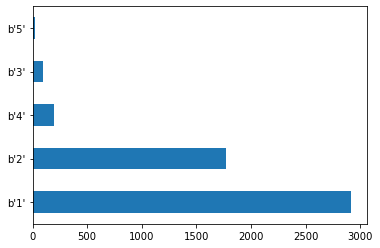

c:\Users\amade\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


['Normal', 'R on T', 'PVC', 'SP', 'UB']
(2919, 140)
{b'2': 'Normal', b'1': 'R on T', b'4': 'PVC', b'3': 'SP', b'5': 'UB'}


In [1]:
from ECG.Ecg_data import dataset
from VAE_LSTM import Encoder, Decoder, RecurrentVAE
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from train import get_weights_file_path

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train, seq_len, n_features, val, test_anomaly, test_normal = dataset()
model = RecurrentVAE(seq_len, n_features, 128).to(device)

['Normal', 'R on T', 'PVC', 'SP', 'UB']
(2919, 140)
{'Normal': 'Normal', 'R on T': 'R on T', 'PVC': 'PVC', 'SP': 'SP', 'UB': 'UB'}


In [3]:
model_filename = get_weights_file_path(f'99')
state = torch.load(model_filename,map_location=torch.device('cpu'))
model.load_state_dict(state['model_state_dict'])

<All keys matched successfully>

In [4]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

c:\Users\amade\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

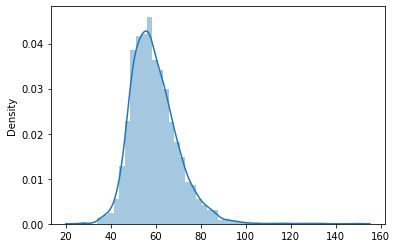

In [11]:
_, losses = predict(model, train)
import seaborn as sns
sns.distplot(losses, bins=50, kde=True)

c:\Users\amade\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

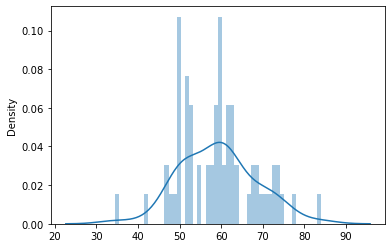

In [12]:
predictions, pred_losses = predict(model, test_normal)
sns.distplot(pred_losses, bins=50, kde=True)

In [13]:
THRESHOLD = 80
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal)}')

Correct normal predictions: 65/66


c:\Users\amade\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

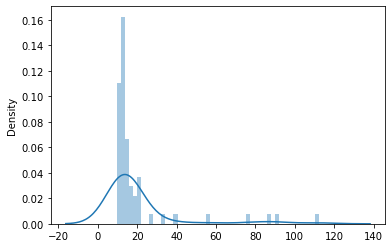

In [14]:
anomaly_dataset = test_anomaly[:len(test_normal)]
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True)


In [17]:
THRESHOLD = 80
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 3/66


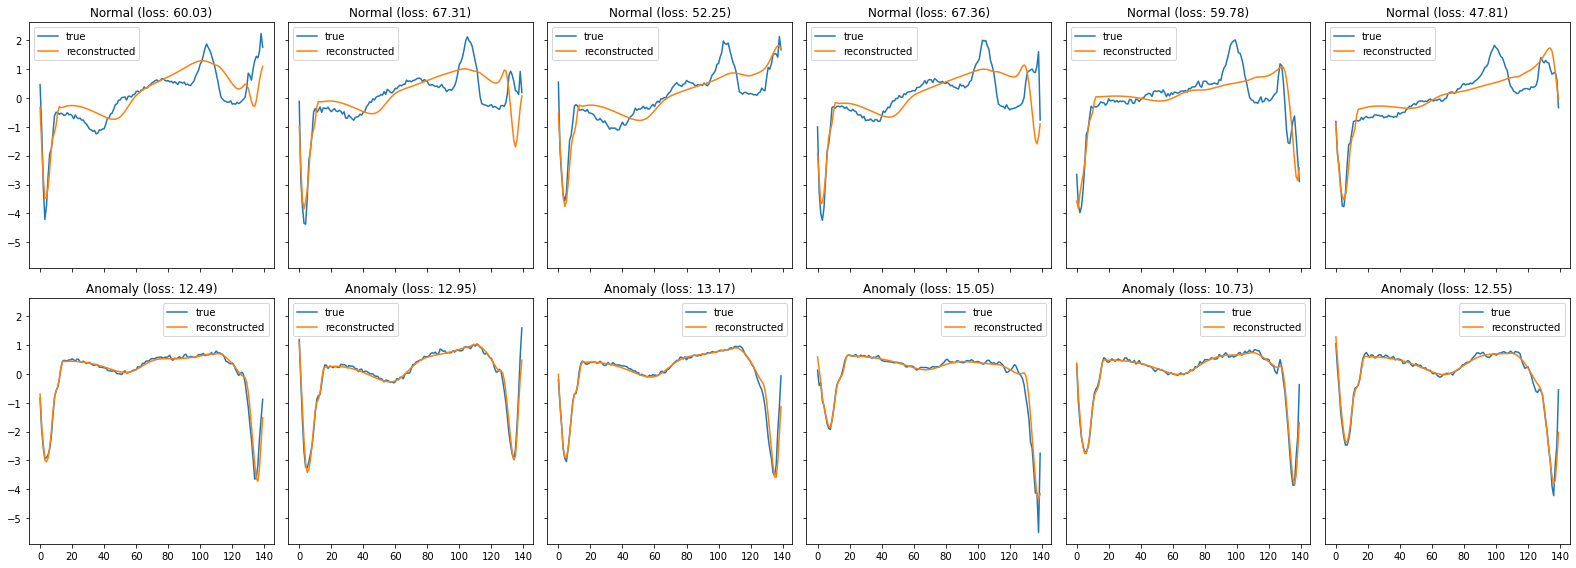

In [18]:
import matplotlib.pyplot as plt
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()


fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()
